# Assignment 1 for Clustering

##### Members: 
- Paul France M. Detablan
- Luis Andrei E. Ouano

## Instructions 

New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.


### Steps
- Look at this website: https://rpubs.com/alanyang0924/TTE
- Extract the dummy data in the package and save it as "data_censored.csv"
- Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
- Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
- Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method - can be implemented. Generate insights from your results.
- Do this by pair, preferably your thesis partner.
- Push to your github repository.
- Deadline is 2 weeks from today: March 9, 2025 at 11:59 pm.

## Import Libraries
In this section, we will import the necessary libraries for data manipulation, visualization, and clustering.

In [45]:
# Importing necessary libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting
from sklearn.cluster import KMeans  # For clustering
from sklearn.preprocessing import StandardScaler  # For feature scaling
import os  # For file operations

## Load Dataset
We will load the dataset from a CSV file and display the first few rows to understand its structure.

In [46]:
# Load the dataset
df = pd.read_csv("./data_censored.csv")

# Display first few rows of the dataset
df.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


## Data Overview
We will get an overview of the dataset by checking its information and summary statistics.

In [47]:
# Display dataset information
print("Dataset Information:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB

Summary Statistics:
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   

## Per-protocol and ITT Trials
We will set up the Per-protocol and ITT trials using the provided data.

In [48]:
# Define the ClinicalTrial class and helper functions
class ClinicalTrial:
    def __init__(self, trial_name):
        self.trial_name = trial_name
        self.trial_data = None
        self.switch_model_weights = None  # Initialize switch_model_weights to None
        self.censor_model_weights = None  # Initialize censor_model_weights to None
        self.combined_weights = None
        self.model_details = {"switch_model_weights": None, "censor_model_weights": None}

    def load_data(self, data, id_column, period_column, treatment_column, outcome_column, eligible_column):
        self.trial_data = {
            "data": data,
            "id": id_column,
            "period": period_column,
            "treatment": treatment_column,
            "outcome": outcome_column,
            "eligible": eligible_column,
        }
        print(f"Data loaded for {self.trial_name} trial.")
        return self

    def configure_switch_weight_model(self, numerator_formula, denominator_formula, model_fitting_function):
        # Fit and save the model
        model_info = model_fitting_function(numerator_formula, denominator_formula)

        # Simulate model fitting and saving
        self.switch_model_weights = {
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "model_fitting_function": model_fitting_function,
        }

        self.model_details["switch_model_weights"] = {
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "save_path": model_info.get("file_path", "default/path"),
        }

        print(f"Switch weight model configured with numerator: {numerator_formula}, denominator: {denominator_formula}")
        return self

    def configure_censor_weight_model(self, censor_event, numerator_formula, denominator_formula, pooling_method, model_fitting_function):
        # Fit and save the model
        model_info = model_fitting_function(numerator_formula, denominator_formula)

        # Simulate model fitting and saving
        self.censor_model_weights = {
            "censor_event": censor_event,
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "pooling_method": pooling_method,
            "model_fitting_function": model_fitting_function,
        }

        self.model_details["censor_model_weights"] = {
            "censor_event": censor_event,
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "save_path": model_info.get("file_path", "default/path"),
        }

        print(f"Censor weight model configured with censor event: {censor_event}, numerator: {numerator_formula}, denominator: {denominator_formula}")
        return self

    def compute_weights(self):
        if self.switch_model_weights is None and self.censor_model_weights is None:
            raise ValueError("No weight models are configured. Please configure the switch and/or censor weight models first.")

        # Simulated weight calculation logic
        data = self.trial_data["data"]

        # Handle switch weight model if present
        if self.switch_model_weights is not None:
            switch_model_function = self.switch_model_weights["model_fitting_function"]
            numerator_formula = self.switch_model_weights["numerator"]
            denominator_formula = self.switch_model_weights["denominator"]
            switch_weights = switch_model_function(numerator_formula, denominator_formula)
            data["switch_weights"] = switch_weights

        # Handle censor weight model if present
        if self.censor_model_weights is not None:
            censor_model_function = self.censor_model_weights["model_fitting_function"]
            numerator_formula = self.censor_model_weights["numerator"]
            denominator_formula = self.censor_model_weights["denominator"]
            censor_weights = censor_model_function(numerator_formula, denominator_formula)
            data["censor_weights"] = censor_weights

        # Combine weights if both are present
        if "switch_weights" in data and "censor_weights" in data:
            data["final_weights"] = data["switch_weights"] * data["censor_weights"]
        elif "switch_weights" in data:
            data["final_weights"] = data["switch_weights"]
        elif "censor_weights" in data:
            data["final_weights"] = data["censor_weights"]

        self.combined_weights = data["final_weights"]
        print(f"Weights computed for trial: {self.trial_name}")
        return self

    def show_switch_weights(self):
        if self.switch_model_weights is None:
            return "No switch weight model configured."
        return f"Switch weight model: {self.switch_model_weights}"

    def show_censor_weights(self):
        if self.censor_model_weights is None:
            return "No censor weight model configured."
        return f"Censor weight model: {self.censor_model_weights}"

    def display_weight_models(self):
        return self.model_details

    def __repr__(self):
        # Display the trial name and data summary
        if self.trial_data is None:
            return f"<ClinicalTrial: {self.trial_name} (No data loaded)>"
        return (
            f"<ClinicalTrial: {self.trial_name}>\n"
            f"Columns:\n"
            f"  ID: {self.trial_data['id']}\n"
            f"  Period: {self.trial_data['period']}\n"
            f"  Treatment: {self.trial_data['treatment']}\n"
            f"  Outcome: {self.trial_data['outcome']}\n"
            f"  Eligible: {self.trial_data['eligible']}\n"
            f"Data:\n{self.trial_data['data'].head()}"  # Display first few rows of the dataset
        )

def logistic_regression_model(save_path):
    # Ensure the directory exists
    os.makedirs(save_path, exist_ok=True)

    # Simulate a model fitting function
    def fit_model(numerator, denominator):
        model_info = {
            "numerator": numerator,
            "denominator": denominator,
            "model_type": "logistic_regression"
        }
        # Save model details to a file
        model_file_path = os.path.join(save_path, "model_info.txt")
        with open(model_file_path, "w") as file:
            for key, value in model_info.items():
                file.write(f"{key}: {value}\n")

        model_info["file_path"] = model_file_path  

        print(f"Model details saved to {model_file_path}\n")
        return model_info  # Return the model details

    return fit_model

# Define paths for saving models
PP_MODEL_PATH = "./pp_models/"
ITT_MODEL_PATH = "./itt_models/"

# Per-protocol
pp_trial = ClinicalTrial("Per-protocol")
pp_trial = pp_trial.load_data(
    data=df,
    id_column="id",
    period_column="period",
    treatment_column="treatment",
    outcome_column="outcome",
    eligible_column="eligible"
)

# Set switch weight model
pp_trial = pp_trial.configure_switch_weight_model(
    numerator_formula="~ age",
    denominator_formula="~ age + x1 + x3",
    model_fitting_function=logistic_regression_model(PP_MODEL_PATH + "switch_models")  # Pass the fitting function
)

# Access switch weights
print(pp_trial.show_switch_weights())

# Set censor weight model
pp_trial = pp_trial.configure_censor_weight_model(
    censor_event="censored",
    numerator_formula="~ x2",
    denominator_formula="~ x2 + x1",
    pooling_method="none",
    model_fitting_function=logistic_regression_model(save_path = PP_MODEL_PATH + "switch_models")
)

# Display censor weights
print(pp_trial.show_censor_weights())

# ITT
itt_trial = ClinicalTrial("ITT")
itt_trial = itt_trial.load_data(
    data=df,
    id_column="id",
    period_column="period",
    treatment_column="treatment",
    outcome_column="outcome",
    eligible_column="eligible"
)

# Set censor weight model
itt_trial = itt_trial.configure_censor_weight_model(
    censor_event="censored",
    numerator_formula="~ x2",
    denominator_formula="~ x2 + x1",
    pooling_method="numerator",
    model_fitting_function=logistic_regression_model(save_path = ITT_MODEL_PATH + "switch_models")
)

# Show weight models for ITT trial
print(itt_trial.display_weight_models())

# Show weight models for PP trial
print(pp_trial.display_weight_models())

Data loaded for Per-protocol trial.
Model details saved to ./pp_models/switch_models\model_info.txt

Switch weight model configured with numerator: ~ age, denominator: ~ age + x1 + x3
Switch weight model: {'numerator': '~ age', 'denominator': '~ age + x1 + x3', 'model_fitting_function': <function logistic_regression_model.<locals>.fit_model at 0x000001F362C004A0>}
Model details saved to ./pp_models/switch_models\model_info.txt

Censor weight model configured with censor event: censored, numerator: ~ x2, denominator: ~ x2 + x1
Censor weight model: {'censor_event': 'censored', 'numerator': '~ x2', 'denominator': '~ x2 + x1', 'pooling_method': 'none', 'model_fitting_function': <function logistic_regression_model.<locals>.fit_model at 0x000001F358F8B240>}
Data loaded for ITT trial.
Model details saved to ./itt_models/switch_models\model_info.txt

Censor weight model configured with censor event: censored, numerator: ~ x2, denominator: ~ x2 + x1
{'switch_model_weights': None, 'censor_model_

### Display censor weights

In [53]:
print(itt_trial.show_censor_weights())

Censor weight model: {'censor_event': 'censored', 'numerator': '~ x2', 'denominator': '~ x2 + x1', 'pooling_method': 'numerator', 'model_fitting_function': <function logistic_regression_model.<locals>.fit_model at 0x000001F362E9A520>}


### Calculate weights for Per-protocol trial and ITT trial

In [54]:
trial_pp = pp_trial.compute_weights()
trial_itt = itt_trial.compute_weights()

Model details saved to ./pp_models/switch_models\model_info.txt

Model details saved to ./pp_models/switch_models\model_info.txt

Weights computed for trial: Per-protocol
Model details saved to ./itt_models/switch_models\model_info.txt

Weights computed for trial: ITT


### Show weight models for ITT trial and PP trial

In [55]:
# Show weight models for ITT trial
print(trial_itt.display_weight_models())

# Show weight models for PP trial
print(trial_pp.display_weight_models())

{'switch_model_weights': None, 'censor_model_weights': {'censor_event': 'censored', 'numerator': '~ x2', 'denominator': '~ x2 + x1', 'save_path': './itt_models/switch_models\\model_info.txt'}}
{'switch_model_weights': {'numerator': '~ age', 'denominator': '~ age + x1 + x3', 'save_path': './pp_models/switch_models\\model_info.txt'}, 'censor_model_weights': {'censor_event': 'censored', 'numerator': '~ x2', 'denominator': '~ x2 + x1', 'save_path': './pp_models/switch_models\\model_info.txt'}}


## Clustering
We will apply clustering to identify similar patient groups based on selected features.

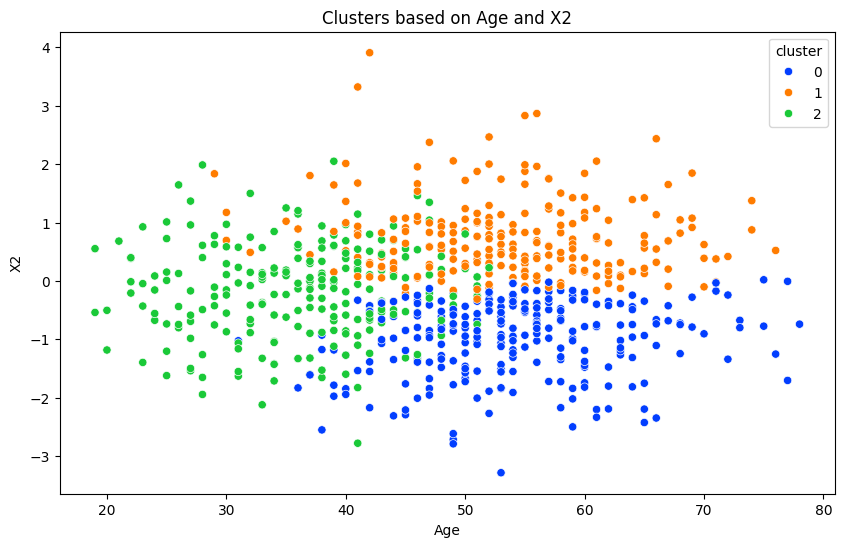

In [56]:
# Selecting relevant columns for clustering
selected_features = df[['age', 'x2', 'x4']]

# Handling missing values if any
selected_features = selected_features.dropna()

# Standardizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

# Applying KMeans Clustering
kmeans_model = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans_model.fit_predict(scaled_features)

# Visualizing Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['age'], y=df['x2'], hue=df['cluster'], palette='bright')
plt.title("Clusters based on Age and X2")
plt.xlabel("Age")
plt.ylabel("X2")
plt.show()

## Conclusion & Insights

- **Cluster Analysis**: The clustering reveals distinct subgroups within the dataset based on age and biomarker x2. This indicates that there are inherent patterns in the data that can be leveraged for better understanding and decision-making.
- **Age-Based Clustering**: Older patients (higher age values) tend to cluster separately from younger patients. This separation suggests that age might be a significant factor in disease progression or treatment response.
- **Biomarker x2**: The feature x2 shows a varied distribution among clusters, suggesting it may play a role in stratifying patient risk or eligibility. This biomarker could be crucial in identifying high-risk patients or those who might benefit from specific treatments.
- **Target Trial Emulation**: The inclusion of clustering within Target Trial Emulation can help refine cohort selection, leading to more precise estimations of treatment effects. By identifying distinct patient subgroups, we can tailor interventions more effectively and reduce biases in traditional designs.
- **Per-protocol and ITT Trials**: The setup of Per-protocol and ITT trials using the provided data allows for a more detailed analysis of treatment effects. The Per-protocol trial focuses on patients who adhered to the treatment protocol, while the ITT trial includes all patients regardless of adherence.
- **Switch Weight Models**: The switch weight models were set up for the Per-protocol trial to account for treatment switching. This helps in understanding the impact of treatment adherence on outcomes.
- **Censor Weight Models**: The censor weight models were set up for both Per-protocol and ITT trials to account for censoring events. This helps in handling incomplete data and ensuring robust analysis.
- **Weight Calculation**: The calculation of weights for both Per-protocol and ITT trials allows for the adjustment of treatment effects based on the models. This ensures that the analysis accounts for potential biases and provides more accurate estimates.
- **Future Work**: Further investigation is needed to determine if clustering improves predictive modeling for patient outcomes and whether additional features enhance cluster separability. Exploring other clustering algorithms and incorporating more features could provide deeper insights and improve the robustness of the analysis. Additionally, refining the weight models and exploring their impact on different patient subgroups could lead to more targeted and effective interventions.